In [1]:
from fileinput import filename

from utils import *

# Load data
This loads results data from the results folder

In [2]:
RESULTS_FOLDER = 'simulations_run_20250411_122833'

# RESULTS_FOLDER = os.path.join('..', 'output', RESULTS_FOLDER)
RESULTS_FOLDER = os.path.join(RESULTS_FOLDER)

SCENARIOS_RENAME = {
    'BAU': 'BAU',
    'baseline': 'baseline',
    'Retrade': 'SAPP Interco Plan',
    'DemandTransmissionIFCEnergySecurity': 'IFC Energy Security',
    'DemandTransmissionIFC': 'IFC Baseline',
}

RESULTS_FOLDER, GRAPHS_FOLDER, dict_specs, epm_input, epm_results, mapping_gen_fuel = process_simulation_results(
    RESULTS_FOLDER, SCENARIOS_RENAME=SCENARIOS_RENAME, folder='')

pInterconUtilizationExtExp not in epm_results.keys().
AdditiononalCapacity_trans not in epm_results.keys().
pInterconUtilizationExtImp not in epm_results.keys().
pYearlyTrade not in epm_results.keys().
Interchange not in epm_results.keys().
pInterchangeExtExp not in epm_results.keys().
interchanges not in epm_results.keys().
pCurtailedVRET not in epm_results.keys().
InterconUtilization not in epm_results.keys().
pCurtailedStoHY not in epm_results.keys().
InterchangeExtImp not in epm_results.keys().
pNPVByYear not in epm_results.keys().
pHourlyFlow not in epm_results.keys().
pFuelDispatch not in epm_results.keys().
annual_line_capa not in epm_results.keys().
pPlantFuelDispatch not in epm_results.keys().
pFuelDispatch not found in epm_dict
pPlantFuelDispatch not found in epm_dict


## Create geographical zone data
Update `geojson_to_epm.csv` in `postprocessing/static/` to define zones.

**Required Columns**:
- **Geojson**: Zone name (must match `countries.geojson`).
- **EPM**: Corresponding zone name in the EPM model.

**Optional (for country subdivisions)**:
- **region**: North, South, East, or West.
- **country**: Country name (must match `countries.geojson`).
- **division**: `'NS'` (North-South) or `'EW'` (East-West).

**Example**:
| Geojson                                  | EPM          | region | country | division |
|------------------------------------------|--------------|--------|--------|----------|
| South Africa                             | South_Africa |        |        |          |
| Namibia                                  | Namibia      |        |        |          |
| Democratic Republic of the Congo - North | DRC          | north  | Democratic Republic of the Congo     | NS       |
| Democratic Republic of the Congo - South | DRC_South    | south  | Democratic Republic of the Congo     | NS       |

Democratic Republic of the Congo is split into North/South; other zones remain the same.

In [4]:
zone_map, geojson_to_epm = get_json_data(epm_results=epm_results, dict_specs=dict_specs)

epm_to_geojson = {v: k for k, v in geojson_to_epm.items()}  # Reverse dictionary

zone_map, centers = create_zonemap(zone_map, map_geojson_to_epm=geojson_to_epm)

## Plots

### Transmission maps

/Users/celia/Documents/WorldBank/Energy_planning/EPM/epm/postprocessing/utils.py:3716: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),


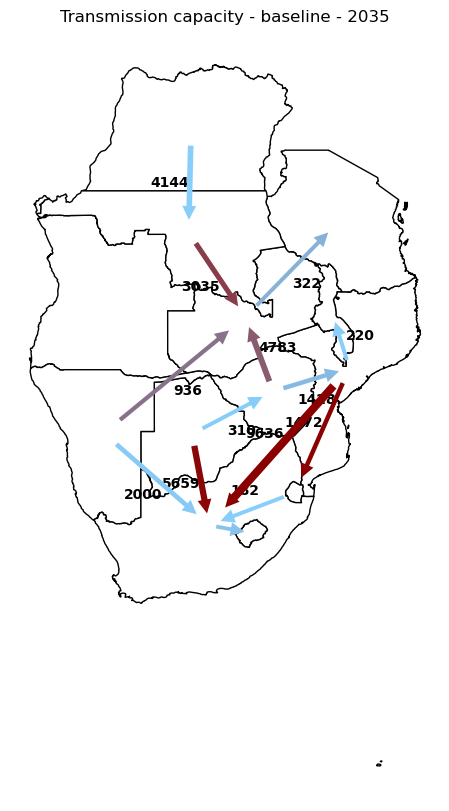

In [6]:
# Plotting exchanges with arrows

tmp = epm_results['pInterchange'].copy()
df_congested = epm_results['pCongested'].copy().rename(columns={'value': 'congestion'})
tmp = tmp.merge(df_congested, on=['scenario', 'year', 'zone', 'z2'], how='left')
tmp = tmp.fillna(0)
tmp_rev = tmp.copy().rename(columns={'zone': 'z2', 'z2': 'zone'})
tmp_rev['value'] = - tmp_rev['value']
df_combined = pd.concat([tmp, tmp_rev], ignore_index=True)
df_combined = df_combined.groupby(['scenario', 'year', 'zone', 'z2'])[['value', 'congestion']].sum().reset_index()
df_net = df_combined[df_combined['value'] > 0]
df_net = df_net.rename(columns={'zone': 'zone_from', 'z2': 'zone_to'})

scenario = 'baseline'
# scenario = 'SAPP Interco Plan'
# scenario = 'IFC Energy Security'

year = 2035

filename = None

make_interconnection_map(zone_map, df_net, centers, filename=filename, year=year, scenario=scenario,
                         label_yoffset=0.01, label_xoffset=-0.05, label_fontsize=10, show_labels=False, plot_colored_countries=False,
                         min_display_value=100, column='value', plot_lines=False, format_y = lambda y, _: '{:.0f}'.format(y), offset=-1.5,
                         min_line_width=0.7, max_line_width=1.5, arrow_linewidth=0.1, mutation_scale=20, color_col='congestion')


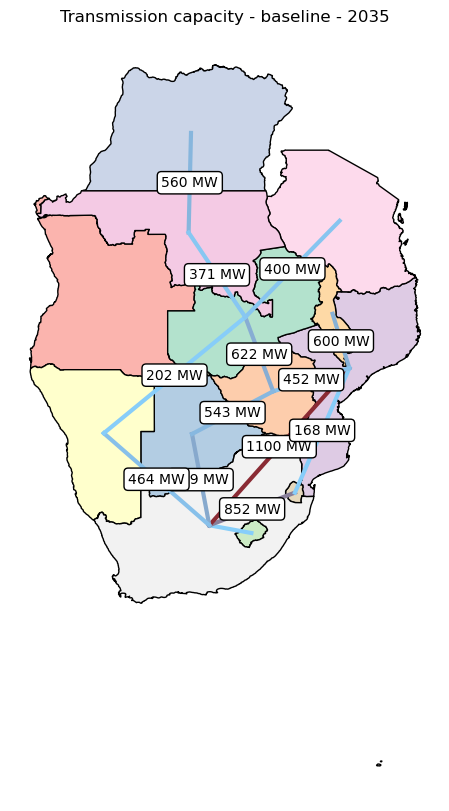

In [7]:
# Plotting transmission lines capacity

capa_transmission = epm_results['pAnnualTransmissionCapacity'].copy()
utilization_transmission = epm_results['pInterconUtilization'].copy()
utilization_transmission['value'] = utilization_transmission['value'] * 100  # percentage
utilization_transmission = keep_max_direction(utilization_transmission)
transmission_data = capa_transmission.rename(columns={'value': 'capacity'}).merge(utilization_transmission.rename
                                                                                  (columns={'value': 'utilization'}),  on=['scenario', 'zone', 'z2', 'year'])
transmission_data = transmission_data.rename(columns={'zone': 'zone_from', 'z2': 'zone_to'})

filename = None

scenario = 'baseline'
year = 2035

make_interconnection_map(zone_map, transmission_data, centers, filename=filename, year=year, scenario=scenario,
                         label_yoffset=0.01, label_xoffset=-0.05, label_fontsize=10, show_labels=False,
                         min_display_value=100, column='capacity')


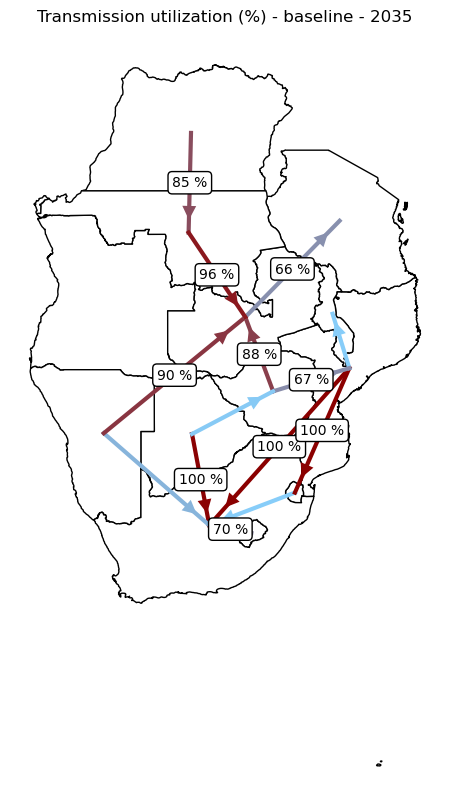

In [8]:
# Plotting transmission lines total utilization

filename = None
scenario = 'baseline'

year = 2035

make_interconnection_map(zone_map, transmission_data, centers, year=year, scenario=scenario,
                         column='utilization',
                         min_capacity=0.01, label_yoffset=0.01, label_xoffset=-0.05,
                         label_fontsize=10, show_labels=False, min_display_value=50,
                         format_y=lambda y, _: '{:.0f} %'.format(y), filename=filename,
                         title='Transmission utilization (%)', show_arrows=True, arrow_offset_ratio=0.4,
                         arrow_size=25, plot_colored_countries=False)

### Capacity

/Users/celia/Documents/WorldBank/Energy_planning/EPM/epm/postprocessing/utils.py:3480: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region_sizes['area'] = region_sizes.geometry.area


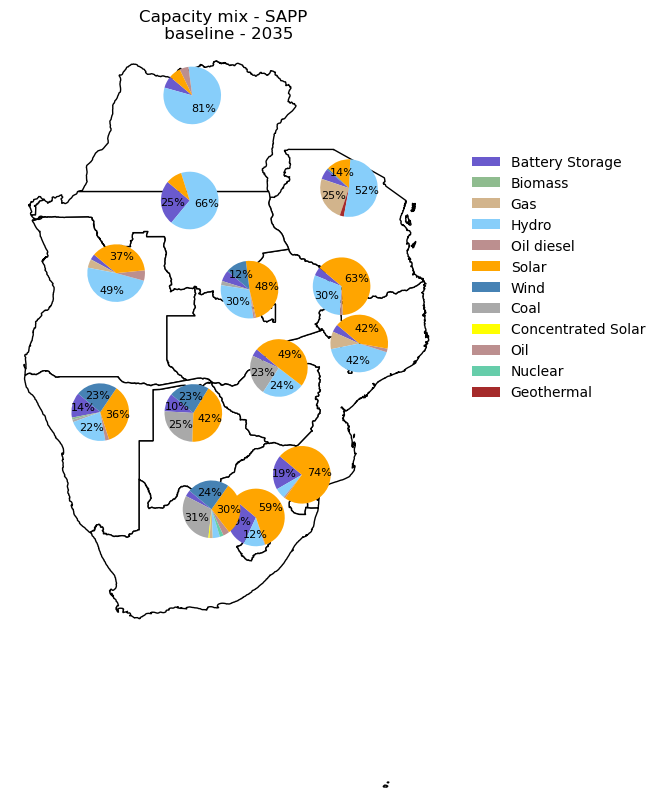

In [9]:
pCapacityByFuel = epm_results['pCapacityByFuel'].copy()
# pCapacityByFuel = pCapacityByFuel.loc[pCapacityByFuel.zone.isin(list(geojson_to_epm.values()))]
filename = None
year = 2035
scenario = 'baseline'

make_capacity_mix_map(zone_map, pCapacityByFuel, dict_specs['colors'], centers, year=year, region='SAPP', scenario=scenario,
                      filename=filename, map_epm_to_geojson=geojson_to_epm, figsize=(12,8), bbox_to_anchor=(0.7, 0.5), loc='center left',  pie_sizing=True,  min_size=2, max_size=2, percent_cap=10)

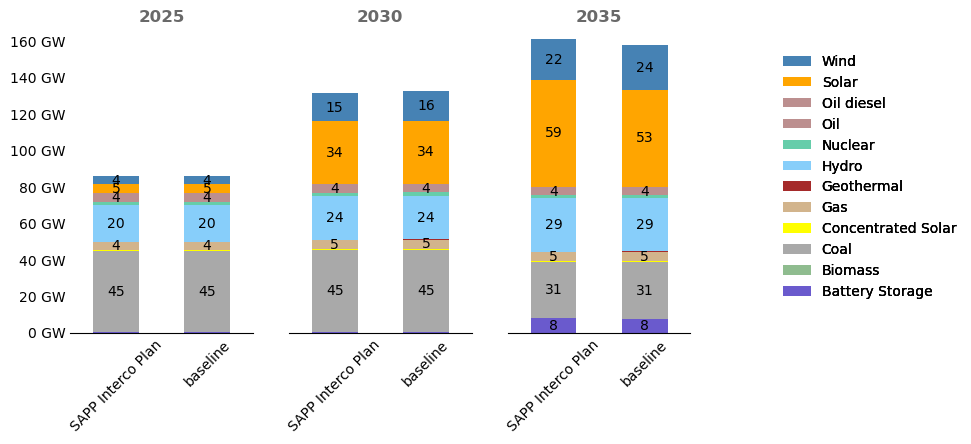

In [11]:
# Capacities as bar plots

df = epm_results['pCapacityByFuel'].copy()
# df = df.loc[df.scenario.isin(['BAU', 'SAPP Interco Plan'])]
df = df.loc[df.scenario.isin(['baseline', 'SAPP Interco Plan'])]
df['value'] = df['value'] / 1e3
filename = None
make_stacked_bar_subplots(df, filename, dict_specs['colors'], column_stacked='fuel',
                          column_xaxis='year', 
                          column_value='value', column_multiple_bars='scenario',
                          select_xaxis=[2025,2030,2035],
                          format_y=lambda y, _: '{:.0f} GW'.format(y), rotation=45, cap=2,
                          format_label="{:.0f}", figsize=(8,4))

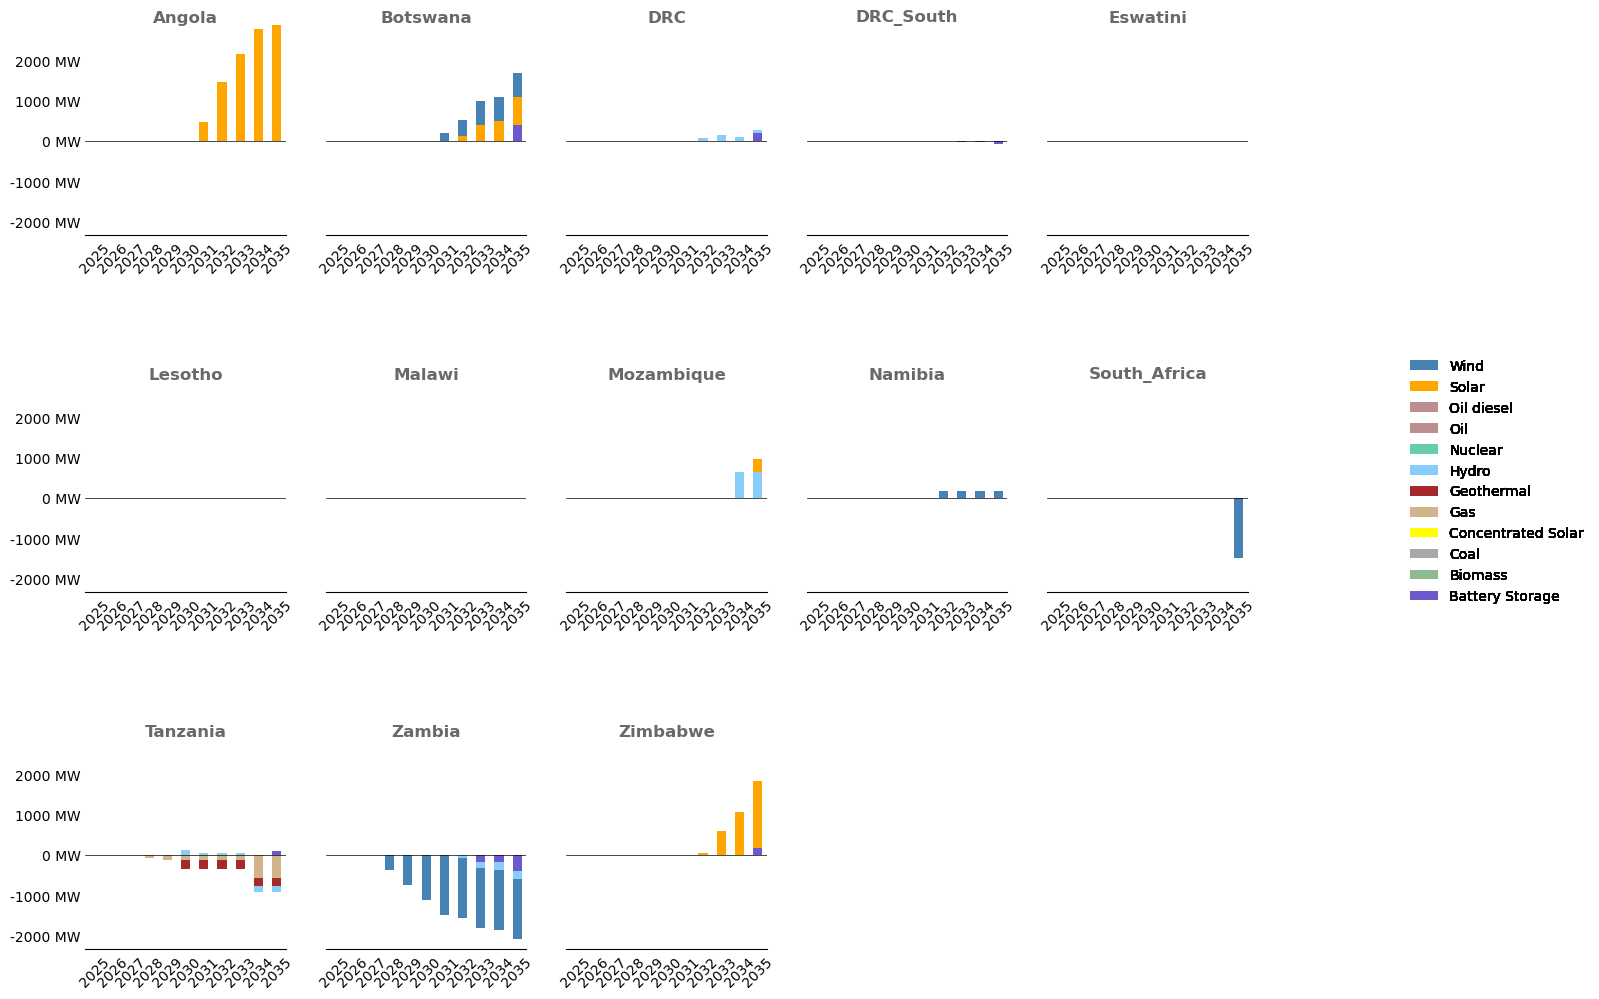

In [13]:
# Bar plot of differences in capacities across scenarios per country

df = epm_results['pCapacityByFuel'].copy()
df = df.loc[df.scenario.isin(['baseline', 'SAPP Interco Plan'])]
# df = df.loc[(df.year == 2035)]
# df = df.loc[(df.scenario == 'Retrade')]
scenario_reference = 'baseline'

if scenario_reference in df['scenario'].unique() and len(df['scenario'].unique()) > 1:
    df_diff = df.pivot_table(index=['zone', 'year', 'fuel'], columns='scenario', values='value', fill_value=0)
    df_diff = (df_diff.T - df_diff[scenario_reference]).T
    df_diff = df_diff.drop(scenario_reference, axis=1)
    df_diff = df_diff.stack().reset_index()
    df_diff.rename(columns={0: 'value'}, inplace=True)

    filename = None # Only for display in the notebook
    make_stacked_bar_subplots(df_diff, filename, dict_colors=dict_specs['colors'], column_stacked='fuel',
                              column_xaxis='zone', column_value='value', column_multiple_bars='year',
                              format_y=lambda y, _: '{:.0f} MW'.format(y), annotate=False, rotation=45,
                              cols_per_row=5, figsize=(15,4), hspace=0.7, show_total=False)

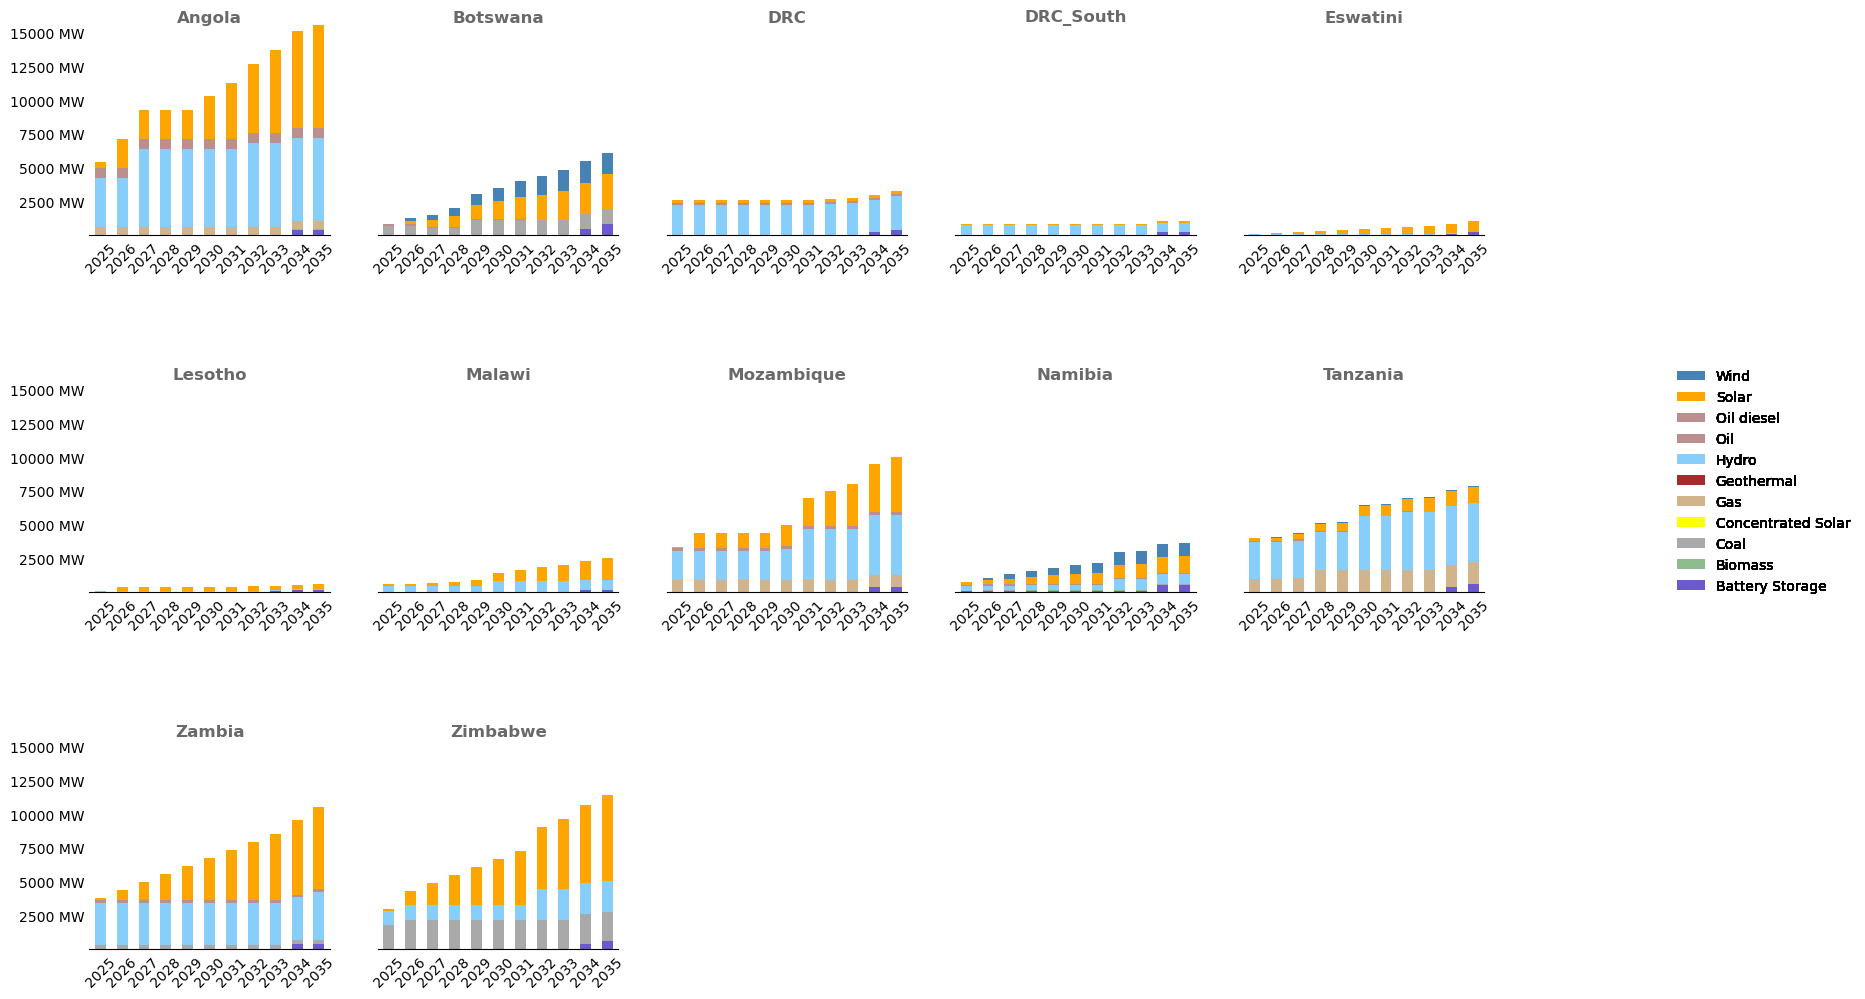

In [14]:
# Bar plot of capacities per country

df = epm_results['pCapacityByFuel'].copy()
df = df.loc[df.scenario.isin(['baseline', 'SAPP Interco Plan'])]
# df = df.loc[(df.year == 2035)]
df = df.loc[(df.scenario == 'SAPP Interco Plan')]
df = df.loc[(df.zone != 'South_Africa')]  # removing South Africa which is one order of magnitude above other countries
# scenario_reference = 'BAU'

filename = None # Only for display in the notebook
make_stacked_bar_subplots(df, filename, dict_colors=dict_specs['colors'], column_stacked='fuel',
                          column_xaxis='zone', column_value='value', column_multiple_bars='year',
                          format_y=lambda y, _: '{:.0f} MW'.format(y), annotate=False, rotation=45,
                          cols_per_row=5, figsize=(18,4), hspace=0.7, show_total=False)


### Energy

/Users/celia/Documents/WorldBank/Energy_planning/EPM/epm/postprocessing/utils.py:3480: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region_sizes['area'] = region_sizes.geometry.area


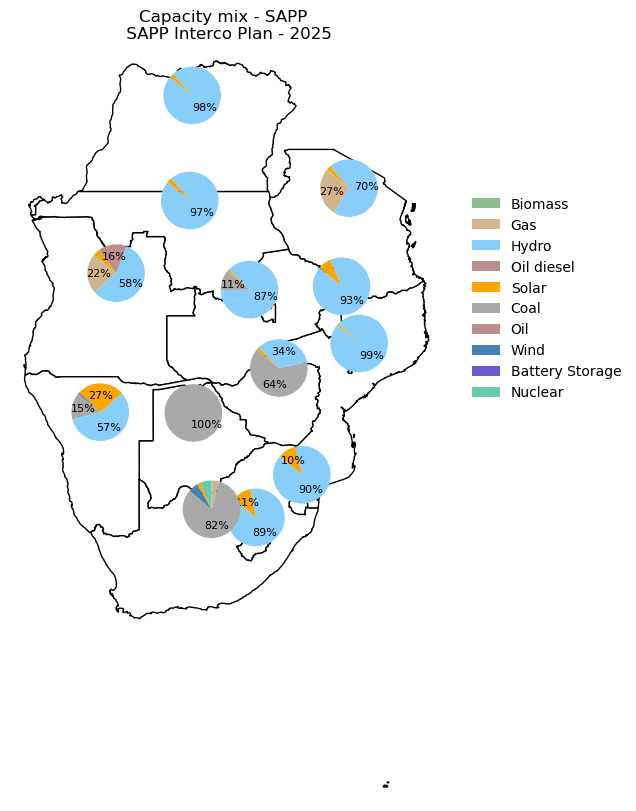

In [15]:
pEnergyByFuel = epm_results['pEnergyByFuel'].copy()

filename = None
year = 2025
scenario = 'SAPP Interco Plan'

make_capacity_mix_map(zone_map, pEnergyByFuel, dict_specs['colors'], centers, year=year, region='SAPP', scenario=scenario,
                      filename=filename, map_epm_to_geojson=geojson_to_epm, figsize=(12,8), bbox_to_anchor=(0.7, 0.5), loc='center left',  pie_sizing=True,  min_size=2, max_size=2, percent_cap=10)

### System costs

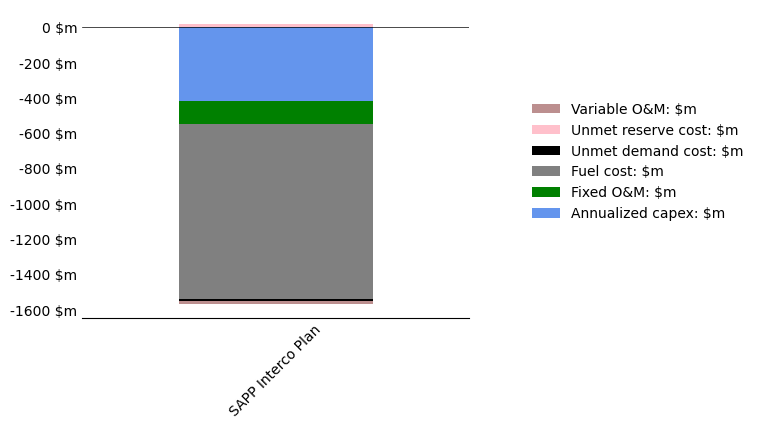

In [16]:
df = epm_results['pSummary'].copy()
df = df.loc[df.scenario.isin(['baseline', 'SAPP Interco Plan'])]  # choosing which scenarios to include in the plot
df = df.set_index(['scenario', 'attribute']).squeeze().unstack(['attribute'])
columns_reserves = ['Sys Spinning Reserve violation: $m', 'Sys Planning Reserve violation: $m',
                    'Zonal Spinning Reserve violation: $m', 'Zonal Planning Reserve violation: $m']
columns_reserves = [c for c in columns_reserves if c in df.columns]
df['Unmet reserve cost: $m'] = sum(df[c] for c in columns_reserves)
df = df.stack().reset_index().rename(columns={0: 'value'})

# choosing which attributes to include in the plot
df = df.loc[df.attribute.isin(["Annualized capex: $m", "Additional transmission costs: $m",
                               "Fixed O&M: $m", "Variable O&M: $m", "Fuel cost: $m", "Unmet demand cost: $m",
                               "Unmet reserve cost: $m", "Spinning reserve costs: $m", "Excess Generation Costs: $m"])]

scenario_ref = 'baseline'  # scenario used for comparison
if scenario_ref in df['scenario'].unique() and len(df['scenario'].unique()) > 1:
    df_diff = df.pivot_table(index=['attribute'], columns='scenario', values='value', fill_value=0)
    df_diff = (df_diff.T - df_diff[scenario_ref]).T
    df_diff = df_diff.drop(scenario_ref, axis=1)
    df_diff = df_diff.stack().reset_index()
    df_diff.rename(columns={0: 'value'}, inplace=True)

    filename = None # Only for display in the notebook
    make_stacked_bar_subplots(df_diff, filename, dict_colors=dict_specs['colors'], column_stacked='attribute',
                              column_xaxis=None, column_value='value', column_multiple_bars='scenario',
                              format_y=lambda y, _: '{:.0f} $m'.format(y), annotate=False, rotation=45,
                              cols_per_row=4, figsize=(5,4), hspace=0.7, show_total=False)

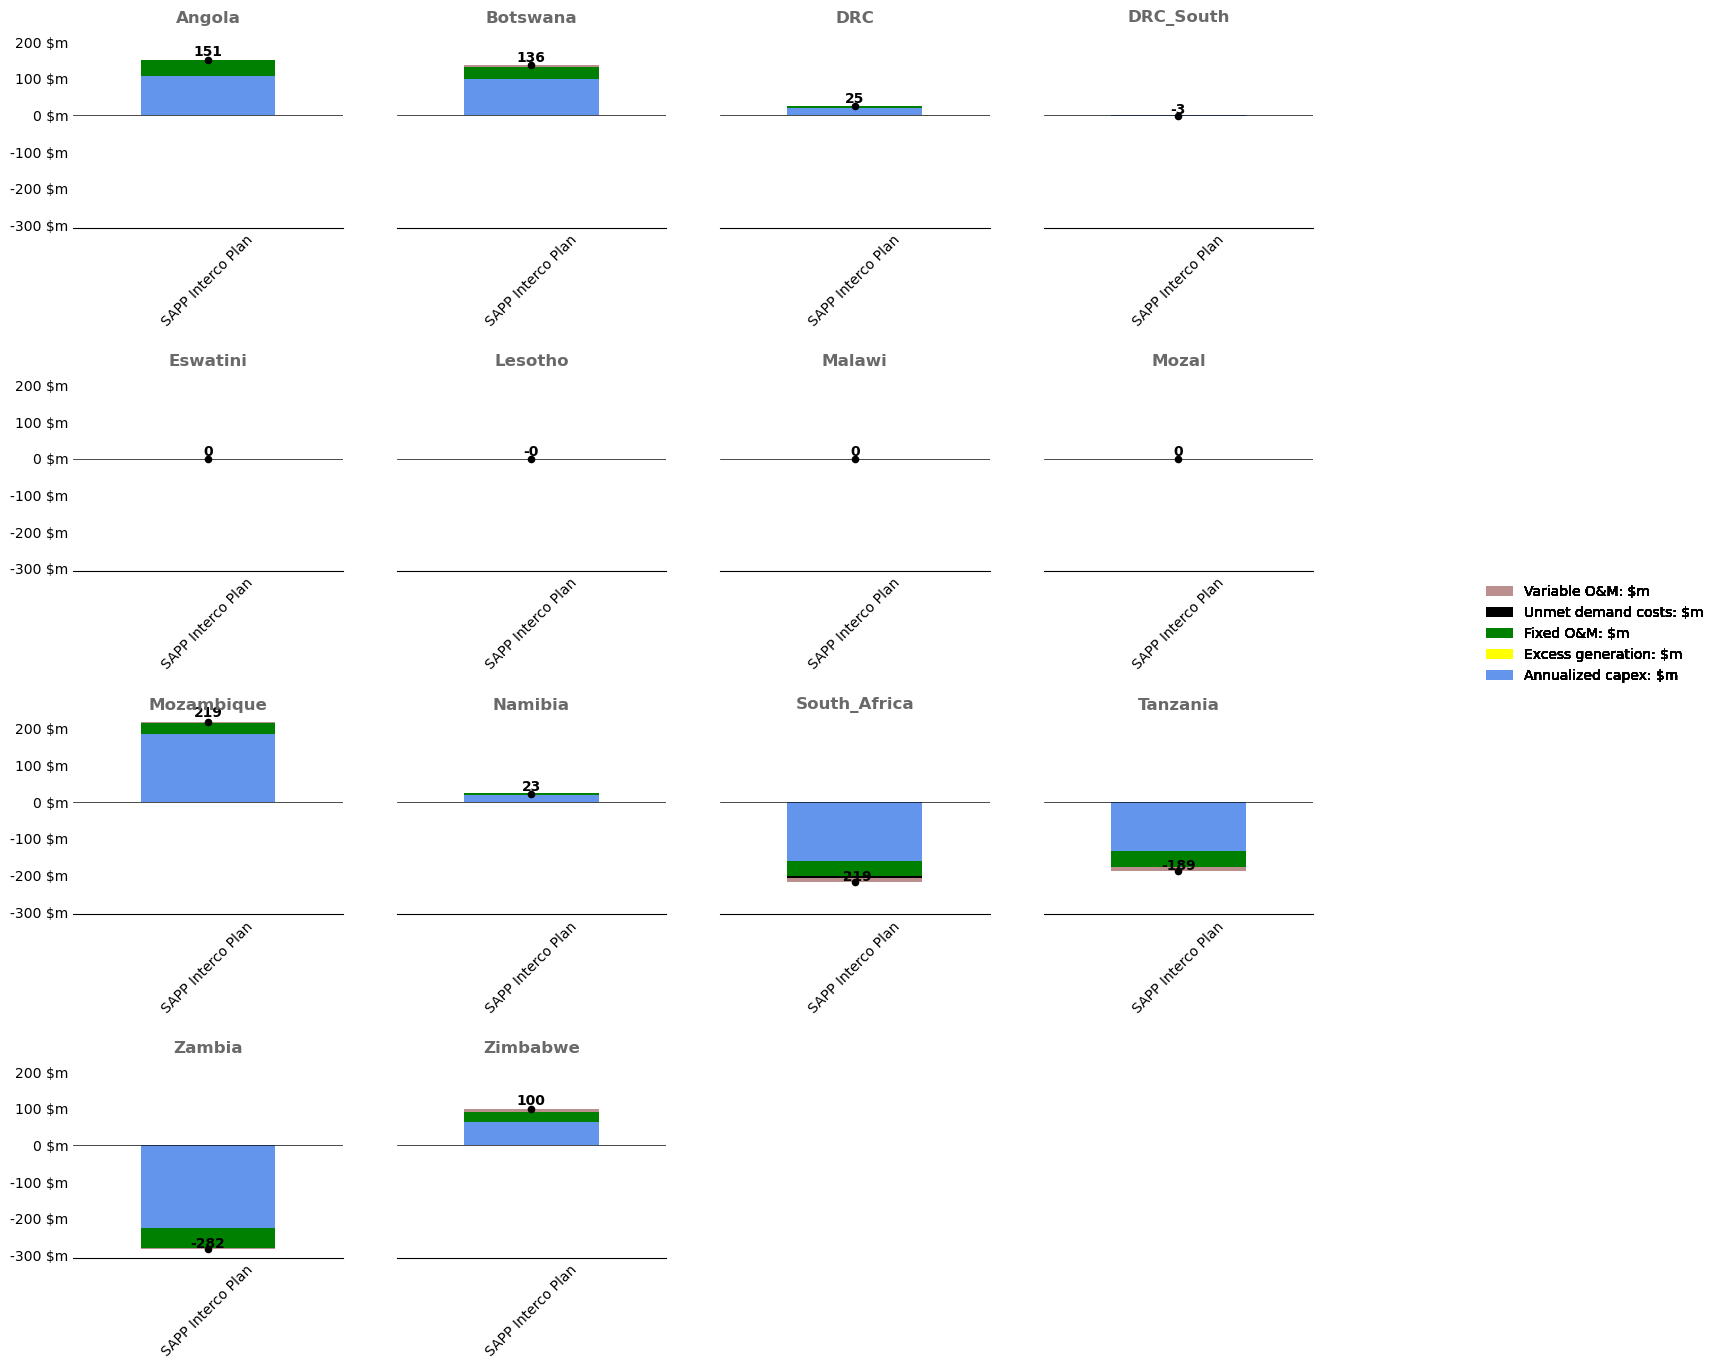

In [17]:
# Variation in costs across scenarios for each country

df = epm_results['pCostSummary'].copy()
df = df.loc[df.scenario.isin(['baseline', 'SAPP Interco Plan'])]  # choosing which scenarios to include in the plot

# choosing which attributes to include in the plot
costs_comparison = ["Annualized capex: $m", "Fixed O&M: $m", "Variable O&M: $m", "Transmission additions: $m",
                    "Spinning Reserve costs: $m", "Unmet demand costs: $m", "Excess generation: $m",
                    "VRE curtailment: $m"]
df = df.loc[df.attribute.isin(costs_comparison)]
df = df.loc[(df.year == 2035)]

scenario_reference = 'baseline'  # scenario used for comparison
if scenario_reference in df['scenario'].unique() and len(df['scenario'].unique()) > 1:
    df_diff = df.pivot_table(index=['zone', 'year', 'attribute'], columns='scenario', values='value', fill_value=0)
    df_diff = (df_diff.T - df_diff[scenario_reference]).T
    df_diff = df_diff.drop(scenario_reference, axis=1)
    df_diff = df_diff.stack().reset_index()
    df_diff.rename(columns={0: 'value'}, inplace=True)

    filename = None
    make_stacked_bar_subplots(df_diff, filename, dict_colors=dict_specs['colors'], column_stacked='attribute',
                              column_xaxis='zone', column_value='value', column_multiple_bars='scenario',
                              format_y=lambda y, _: '{:.0f} $m'.format(y), annotate=False, rotation=45,
                              cols_per_row=4, figsize=(16,4), hspace=0.7, show_total=True)

### Dispatch

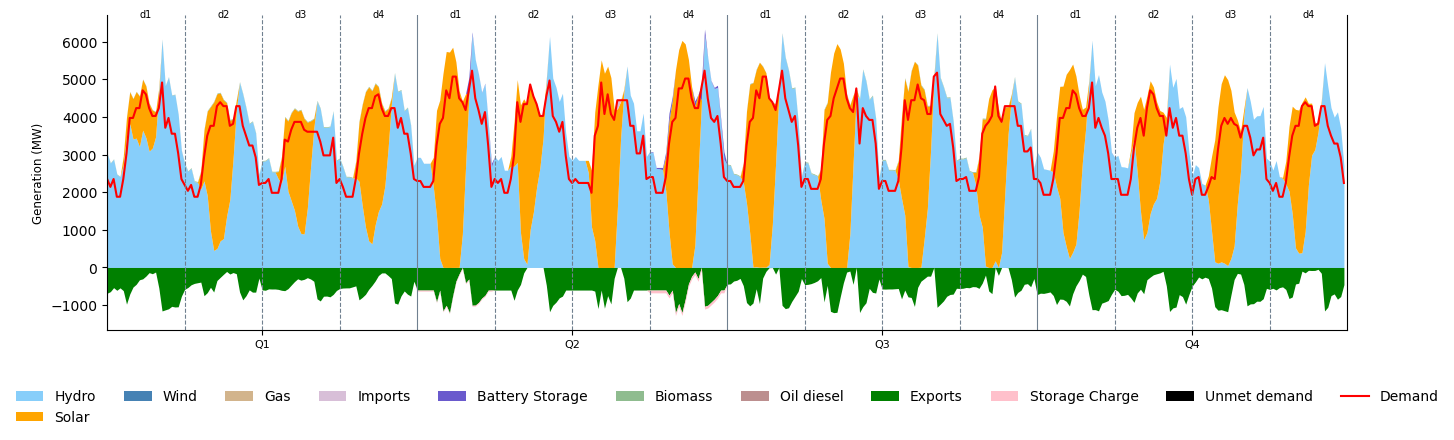

In [18]:

pDispatch = epm_results['pDispatch'].copy()
pPlantDispatch = epm_results['pPlantDispatch'].copy()

dfs_to_plot_area = {
    'pPlantDispatch': filter_dataframe(pPlantDispatch, {'attribute': ['Generation']}),
    'pDispatch': filter_dataframe(pDispatch, {'attribute': ['Unmet demand', 'Exports', 'Imports', 'Storage Charge']})
}

dfs_to_plot_line = {
    'pDispatch': filter_dataframe(pDispatch, {'attribute': ['Demand']})
}

seasons = pPlantDispatch.season.unique()
days = pPlantDispatch.day.unique()

select_time = {'season': ['Q1', 'Q2', 'Q3', 'Q4'], 'day': days}
# select_time = {'season': ['Q4'], 'day': days}
year = 2035
scenario = 'SAPP Interco Plan'
zone = 'Angola'

filename = None

make_complete_fuel_dispatch_plot(dfs_area=dfs_to_plot_area, dfs_line=dfs_to_plot_line, dict_colors=dict_specs['colors'],
                                 zone=zone, year=year, scenario=scenario, select_time=select_time, filename=filename,  figsize=(16,5),
                                 reorder_dispatch=['Hydro', 'Solar', 'Wind', 'Nuclear', 'Coal', 'Oil', 'Gas', 'Imports', 'Battery Storage'], stacked=True, bottom=None)